## Import libraries

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

## Specify hyperparameters

In [13]:
# Paths of the dataset
train_dir = 'train/'
test_dir = 'test/'

# Hyperparameters of our model
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (299,299),
    epochs = 5,
    patience = 5
)

## Data loading and augmentation

In [14]:
# Augment train set only
train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

## Set up image generators for training, validation, and testing, and obtain the number of samples and classes

In [15]:
# Connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Classes:['cats', 'dogs']


## Visualize a sample of 9 augmented training images along with their labels (cat or dog

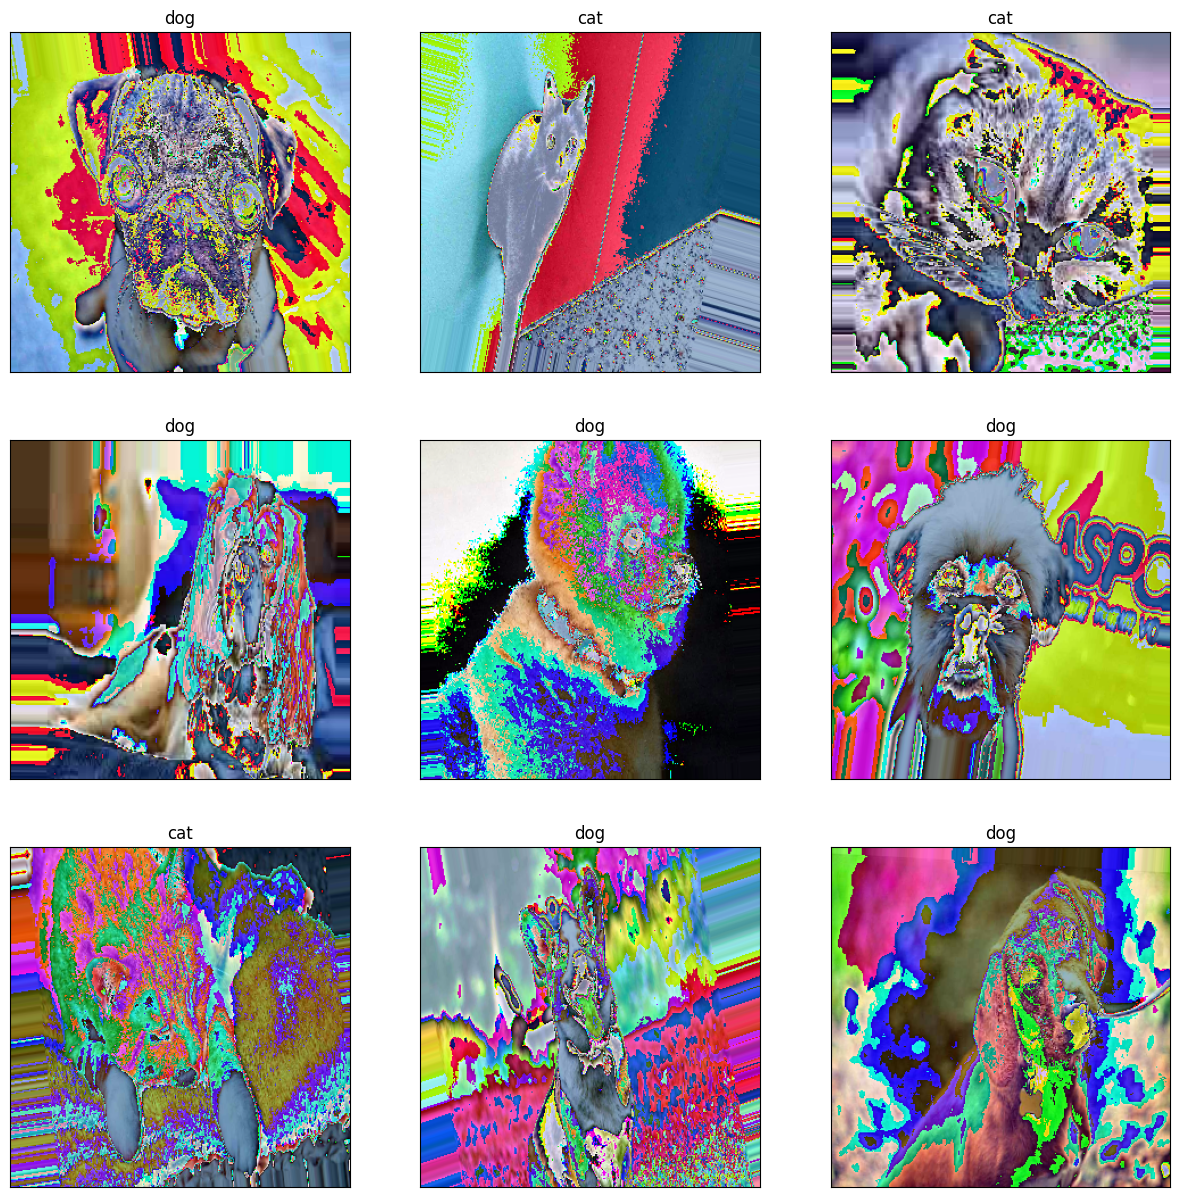

In [16]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()

## Build the InceptionResNetV2 model 
### Here we will use the weights of the ResNet50 based on the CNN

In [17]:
# Pre-trained deep convolutional neural network
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 1s 0us/step


## Set up callbacks for saving the best model and early stopping during model trainingSet up callbacks for saving the best model and early stopping during model training

In [18]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

## Build our model
#### Our model is based on InceptionResNetV2

In [19]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/5
29/29 [==============================] - ETA: 0s - loss: 1.1202 - accuracy: 0.8410
Epoch 1: val_loss improved from inf to 0.10461, saving model to model.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 18s 503ms/step - loss: 1.1202 - accuracy: 0.8410 - val_loss: 0.1046 - val_accuracy: 0.9625
Epoch 2/5
29/29 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9891
Epoch 2: val_loss improved from 0.10461 to 0.03430, saving model to model.h5
29/29 [==============================] - 13s 439ms/step - loss: 0.0208 - accuracy: 0.9891 - val_loss: 0.0343 - val_accuracy: 0.9750
Epoch 3/5
29/29 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9847
Epoch 3: val_loss did not improve from 0.03430
29/29 [==============================] - 12s 428ms/step - loss: 0.0363 - accuracy: 0.9847 - val_loss: 0.1627 - val_accuracy: 0.9375
Epoch 4/5
29/29 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9869
Epoch 4: val_loss did not improve from 0.03430
29/29 [==============================] - 13s 435ms/step - loss: 0.0436 - accuracy: 0.9869 - val_loss: 0.1615 - val_accuracy: 0.9500
Epoch 5/5
29/29 [=====

## Visualize training history by plotting training and validation loss, and accuracy across epochs

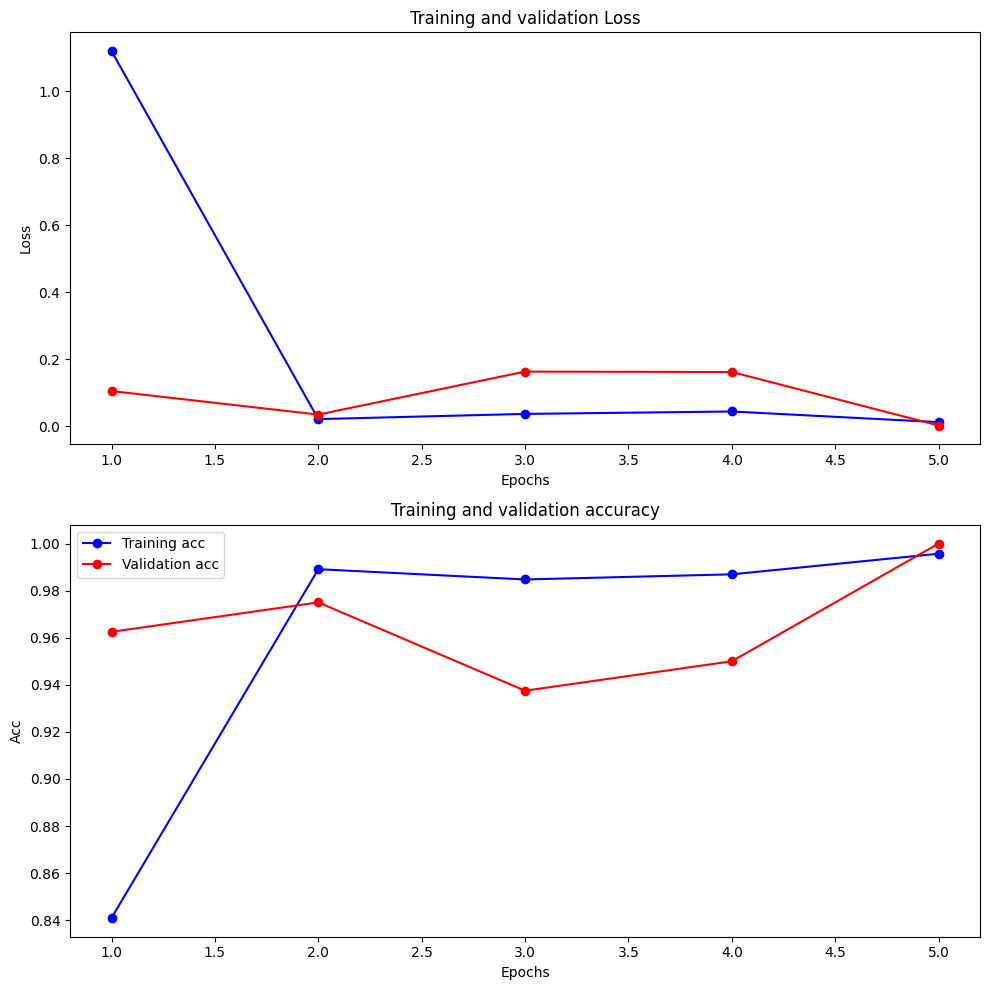

In [23]:
# History
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Loss
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()

## Print the validation accuracy

In [24]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])


Val loss: 0.0016855675494298339
Val accuracy: 1.0


## Print the test accuracy

In [22]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5048043131828308
Test accuracy: 0.9428571462631226
